In [1]:
using Plots, Random, Roots, FFTW, LaTeXStrings, DynamicalSystems, StatsBase

import PyPlot;
const plt = PyPlot;

#cd(dirname(@__FILE__));

# parameters
# physical cavity photon lifetime (and norm time)
tphys = 7.0 * 10^(-12);

# QW parameters
tg = 0.1 * 10^(-9);

# QD parameters
tρ = 0.1 * 10^(-9);
tn = 0.1 * 10^(-9);

delayphys = 0.7 * 10^(-9);

# normalized material parameters
# QW
etag = tphys / tg;

# QD
g = 1.15;
B = 924;
etaρ = tphys / tρ;
etan = tphys / tn;

α = 2;

# pump
JthrQW = 1;
JthrQD = ((1 + g) * (-B + g + B * g)) / (B * (-1 + g) * g);
nJthr = 1.5;
JQW = JthrQW * nJthr;
JQD = JthrQD * nJthr;

# optical feedback
τdelay = delayphys / tphys;
γ = 0.00;
ϕ = 0;
ϕs = [0, 0, 0];

# neighbor coupling
κ = 0.12;

# vectors of parameters
p0QW = [JQW, etag, α, γ, ϕ, ϕs[1], ϕs[2], ϕs[2], κ, τdelay];
p0QD = [JQD, g, B, etaρ, etan, α, γ, ϕ, ϕs[1], ϕs[2], ϕs[2], κ, τdelay];

p0QD4 = [JQD, g, B, etaρ, etan, α, γ, ϕ, ϕs[1], ϕs[2], ϕs[2], ϕs[2], κ, τdelay];

t0 = 0;

# integration procedure parameters
dt = τdelay / 10000;
hist_len = floor(Int, τdelay / dt);
endtime = 400 * τdelay;
num_iter = floor(Int, endtime / dt);
n_lasers = 4
dimQW = n_lasers * 3; # problem dimension QW
dimQD = n_lasers * 4; # problem dimension QD
savnum = 500; # number of points per delay to save
modstep = floor(Int, hist_len / savnum);


Reind = zeros(Int,n_lasers)
Imind = zeros(Int,n_lasers)

# switch QW and QD
isQW = false;
if isQW
    p0 = copy(p0QW)
    dim = dimQW
    tauind = 10
    #Reind = [1,4,7]
    #Imind = [2,5,8]
    for i = 1:n_lasers
        Reind[i] = (i - 1)*3 + 1
        Imind[i] = (i - 1)*3 + 2
    end
else
    if n_lasers == 3
        p0 = copy(p0QD)
        tauind = 13
    else
        p0 = copy(p0QD4)
        tauind = 14
    end
    dim = dimQD
    #Reind = [1,5,9]
    #Imind = [2,6,10]
    
    for i = 1:n_lasers
        Reind[i] = (i - 1)*4 + 1
        Imind[i] = (i - 1)*4 + 2
    end
end

In [2]:
k12 = 1.0
k13 = 1.0
k14 = 1.0
k23 = 1.0
k24 = 1.0
k34 = 1.0

num_iter

4000000

In [3]:
## function evaluating the derivatives for the iteration with the noise terms
# QW problem
# u is the dependent variables vector for three lasers
# indices u[1:4] are for ℜ, ℑ, ρ, n for the first laser
# u[5:8] for the second
# u[9:12] for the third
# uT is the corresponding delayed dependent variables vector
# p is the parameter vector
# p[1] - J
# p[2] - etag
# p[3] - α
# p[4] - γ
# p[5] - ϕ
# p[6] - ϕs[1]
# p[7] - ϕs[2]
# p[8] - ϕs[2]
# p[9] - κ
# p[10] - τdelay

function QW(u, E1, E2, ET1, ET2, ET3, p, nt)
    dF =
        0.5 * (1 - im * p[3]) * (u[3] - 1) * (u[1] + im * u[2]) +
        im *
        p[4] *
        exp(-im * p[5]) *
        (exp(-im * p[6]) * ET1 + exp(-im * p[7]) * ET2 + exp(-im * p[8]) * ET3) +
        im * p[9] * (E1 + E2)

    dn = p[2] * (p[1] - u[3] * (1 + u[1]^2 + u[2]^2))

    return [real(dF), imag(dF), dn]
end

function CoupledQW(u, uT, p, nt, t, t0)
    du1 = QW(
        u[1:3],
        u[4] + im * u[5],
        u[7] + im * u[8],
        uT[1] + im * uT[2],
        uT[4] + im * uT[5],
        uT[7] + im * uT[8],
        p,
        nt,
    )

    du2 = QW(
        u[4:6],
        u[1] + im * u[2],
        u[7] + im * u[8],
        uT[1] + im * uT[2],
        uT[4] + im * uT[5],
        uT[7] + im * uT[8],
        p,
        nt,
    )

    du3 = QW(
        u[7:9],
        u[1] + im * u[2],
        u[4] + im * u[5],
        uT[1] + im * uT[2],
        uT[4] + im * uT[5],
        uT[7] + im * uT[8],
        p,
        nt,
    )

    return collect(Iterators.flatten([du1, du2, du3]))
end

CoupledQW (generic function with 1 method)

In [4]:
# QD problem
# u is the dependent variables vector for three lasers
# indices u[1:4] are for ℜ, ℑ, ρ, n for the first laser
# u[5:8] for the second
# u[9:12] for the third
# uT is the corresponding delayed dependent variables vector
# p is the parameter vector
# p[1] - J
# p[2] - g
# p[3] - B
# p[4] - etaρ
# p[5] - etan
# p[6] - α
# p[7] - γ
# p[8] - ϕ
# p[9] - ϕs[1]
# p[10] - ϕs[2]
# p[11] - ϕs[2]
# p[12] - κ
# p[13] - τdelay

function FU(ρ, n, B)
    return B * n * (1 - ρ)
end

function QD(u, E1, E2, ET1, ET2, ET3, p, nt)
    dF =
        0.5 * ((1 - im * p[6]) * (p[2] * (2 * u[3] - 1) - 1)) * (u[1] + im * u[2]) +
        im *
        p[7] *
        exp(-im * p[8]) *
        (exp(-im * p[9]) * ET1 + exp(-im * p[10]) * ET2 + exp(-im * p[11]) * ET3) +
        im * p[12] * (E1 + E2)

    dρ = p[4] * (FU(u[3], u[4], p[3]) - u[3] - (2 * u[3] - 1) * (u[1]^2 + u[2]^2))

    dn = p[5] * (p[1] - u[4] - 2 * FU(u[3], u[4], p[3]))

    return [real(dF), imag(dF), dρ, dn]
end

du = [ [0.0,0.0,0.0,0.0] for i = 1:3  ]
#
function CoupledQD(u, uT, p, nt, t, t0)
    
    du1 = QD(
        u[1:4],
        u[5] + im * u[6],
        u[9] + im * u[10],
        uT[1] + im * uT[2],
        uT[5] + im * uT[6],
        uT[9] + im * uT[10],
        p,
        nt,
    )

    du2 = QD(
        u[5:8],
        u[1] + im * u[2],
        u[9] + im * u[10],
        uT[1] + im * uT[2],
        uT[5] + im * uT[6],
        uT[9] + im * uT[10],
        p,
        nt,
    )

    du3 = QD(
        u[9:12],
        u[1] + im * u[2],
        u[5] + im * u[6],
        uT[1] + im * uT[2],
        uT[5] + im * uT[6],
        uT[9] + im * uT[10],
        p,
        nt,
    )
    
    return collect(Iterators.flatten([du1, du2, du3]))
    """

    uti1 = [5,1,1]
    uti2 = [9,9,5]


    for i = 1:3
        du[i] = QD(
            u[((i - 1)*4 + 1): ((i - 1)*4 + 4)],
            u[uti1[i]] + im * u[uti1[i] + 1],
            u[uti2[i]] + im * u[uti2[i] + 1],
            uT[1] + im * uT[2],
            uT[5] + im * uT[6],
            uT[9] + im * uT[10],
            p,
            nt,
        )
    end
    return collect(Iterators.flatten(du))"""
end

CoupledQD (generic function with 1 method)

In [5]:
function QD4(u, E1, E2, E3, ET1, ET2, ET3, ET4, p, nt)
    dF =
        0.5 *
        ((1 - im * p[6]) * (p[2] * (2 * u[3] - 1) - 1)) *
        (u[1] + im * u[2]) +
        im *
        p[7] *
        exp(-im * p[8]) *
        (
            exp(-im * p[9]) * ET1 +
            exp(-im * p[10]) * ET2 +
            exp(-im * p[11]) * ET3 +
            exp(-im * p[12]) * ET4
        ) +
        im * p[13] * (E1 + E2 + E3)

    dρ =
        p[4] *
        (FU(u[3], u[4], p[3]) - u[3] - (2 * u[3] - 1) * (u[1]^2 + u[2]^2))

    dn = p[5] * (p[1] - u[4] - 2 * FU(u[3], u[4], p[3]))

    return [real(dF), imag(dF), dρ, dn]
end


function CoupledQD4(u, uT, p, nt, t, t0)

    du = [[0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0]]

    du[1] = QD4(
        u[1:4],
        (u[5] + im * u[6]) * k12,
        (u[9] + im * u[10]) * k13,
        (u[13] + im * u[14]) * k14,
        
        uT[1] + im * uT[2],
        uT[5] + im * uT[6],
        uT[9] + im * uT[10],
        uT[13] + im * uT[14],
        p,
        nt,
    )
    du[2] = QD4(
        u[5:8],
        (u[1] + im * u[2]) * k12,
        (u[9] + im * u[10]) * k23,
        (u[13] + im * u[14]) * k24,
        
        uT[1] + im * uT[2],
        uT[5] + im * uT[6],
        uT[9] + im * uT[10],
        uT[13] + im * uT[14],
        p,
        nt,
    )

    du[3] = QD4(
        u[9:12],
        (u[1] + im * u[2]) * k13,
        (u[5] + im * u[6]) * k23,
        (u[13] + im * u[14]) * k34,
        
        uT[1] + im * uT[2],
        uT[5] + im * uT[6],
        uT[9] + im * uT[10],
        uT[13] + im * uT[14],
        p,
        nt,
    )
    du[4] = QD4(
        u[13:16],
        (u[1] + im * u[2]) * k14,
        (u[5] + im * u[6]) * k24,
        (u[9] + im * u[10]) * k34,
        
        uT[1] + im * uT[2],
        uT[5] + im * uT[6],
        uT[9] + im * uT[10],
        uT[13] + im * uT[14],
        p,
        nt,
    )

    return collect(Iterators.flatten(du))
end


CoupledQD4 (generic function with 1 method)

In [6]:
#arr = zeros(num_iter)
arr = 0
## Semi-implicit Euler iteration procedure
# rhs should be the function of the form rhs(u,uT,p,nt,t,t0)
# SIEiters alterates qY, qYhead, qYtail and U
function SIEiters(rhs, num_iter, modstep, T, p, nt, qY1, qY2, qYtail, U, tind)
    # dimensions
    dim = size(qY1, 1)
    # length of the stored history
    hist_len = size(qY1, 2)
    # array with the current intermediate values of the function
    Y1 = zeros(dim)
    Y2 = zeros(dim)
    # them delayed
    YT1 = zeros(dim)
    YT2 = zeros(dim)

    # local variable for the tail
    lqYtail = qYtail[1]

    # initial values of the unknown
    Y1 = qY1[:, lqYtail]

    # local time variables
    t0 = T[1]
    tc = T[2]
    dt = T[3]

    # fixed tau
    ft = floor(Int, p[tind] / dt)

    # RK iterations
    for l = 1:num_iter
        if !isQW
            p[2] = g
            if size(x,1) > l
                p[2] = g + g * (x[l])
            end
            #arr[l] = p[2]
        end
        
        # reading the time-delayed value of variables
        # the queue is stored in an array qY
        # the first index of qY is the number of the integration method subiteration
        # the second index is the point number inside the queue
        # the tail of the queue corresponds to the (t-dt) variables
        di = lqYtail - ft + 1
        if di < 1
            YT1 = qY1[:, hist_len+di]
            YT2 = qY2[:, hist_len+di]
        else
            YT1 = qY1[:, di]
            YT2 = qY2[:, di]
        end

        ntl = nt[l, :]

        # some semi-implicit calculations
        Y2 = Y1 + dt * rhs(Y1, YT1, p, ntl, tc, t0)

        # storing the time-delayed variables
        lqYtail = mod(lqYtail, hist_len) + 1
        qY1[:, lqYtail] = Y1
        qY2[:, lqYtail] = Y2

        # calculate the actual current-time variable
        Y1 = Y1 + dt * rhs(Y2, YT2, p, ntl, tc + dt, t0)

        # integration output
        if mod(l, modstep) == 0
            U[div(l, modstep), :] = Y1
        end

        tc = tc + dt
    end
    T[2] = tc
    qYtail[1] = lqYtail
end

SIEiters (generic function with 1 method)

In [7]:
## our initial history for SIE method subiterations
Random.seed!(1234)

qY1 = zeros(dim, hist_len);
qY2 = zeros(dim, hist_len);
for i = 1:hist_len
    qY1[:, i] = randn(dim) .^ 2
    qY1[:, i] = qY1[:, i] ./ maximum(qY1[:, i]) / 1000
    qY2[:, i] = randn(dim) .^ 2
    qY2[:, i] = qY2[:, i] ./ maximum(qY2[:, i]) / 1000
end

    

#### В качестве входного сигнала был загружен тестовый аудиофайл

In [ ]:
using FileIO: load, save, loadstreaming, savestreaming
import LibSndFile

x = load("1609518506_funk-2.wav");
#x = x[1][:,1]./ maximum(x[1][:,1]);

#### Позже, для простоты, он был заменен на ступенчатый сигнал

In [8]:
x = zeros(num_iter)
for i = div(num_iter,2):num_iter
    x[i] = 1
end

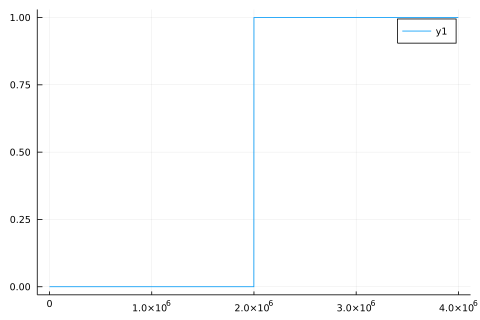

In [9]:
p_1 = plot(
    1:1000:size(x,1),
    x[1:1000:size(x,1)],
    dpi=80,
)

In [71]:
Random.seed!(1)
k12 = rand(0:1000)/1000.0
println(k12)
k13 = rand(0:1000)/1000.0
println(k13)
k14 = rand(0:1000)/1000.0
println(k14)
k23 = rand(0:1000)/1000.0
println(k23)
k24 = rand(0:1000)/1000.0
println(k24)
k34 = rand(0:1000)/1000.0
println(k34)

0.357
0.106
0.956
0.326
0.416
0.958


In [10]:
## integration
U = zeros(div(num_iter, modstep), dim)

qYtail = [1];

Random.seed!(1234)

time_array = [t0, t0, dt]

# noise terms
nt = zeros(num_iter, 2);

#### Произведена симуляция взаимодействия лазеров с единичными коэффициентами

In [71]:
k12 = 1.0
k13 = 1.0
k14 = 1.0
k23 = 1.0
k24 = 1.0
k34 = 1.0

if isQW
    @time SIEiters(CoupledQW, num_iter, modstep, time_array, p0, nt, qY1, qY2, qYtail, U, tauind)
else
    if n_lasers == 3
        @time SIEiters(CoupledQD, num_iter, modstep, time_array, p0, nt, qY1, qY2, qYtail, U, tauind)
    else
        @time SIEiters(CoupledQD4, num_iter, modstep, time_array, p0, nt, qY1, qY2, qYtail, U, tauind)
    end 
end

 31.079907 seconds (508.00 M allocations: 28.372 GiB, 13.78% gc time)


1

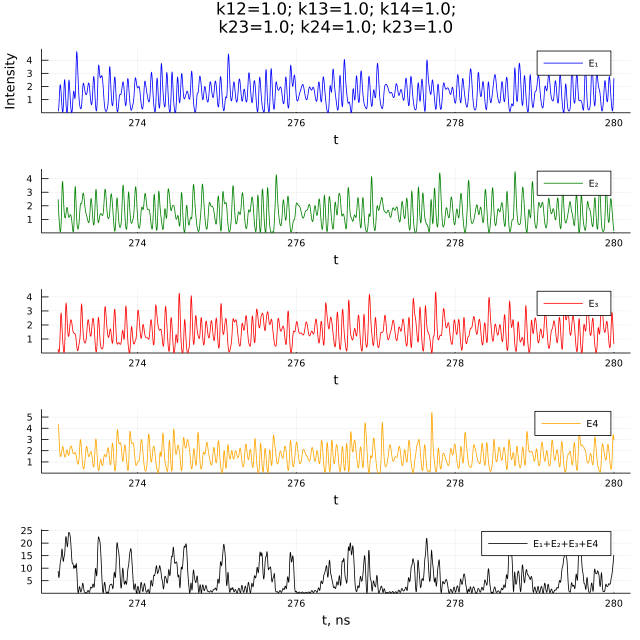

In [65]:
pl_st_t = endtime - 10 * τdelay;
pl_en_t = endtime;
n = 3000; # number of timepoints for plot
pl_st_in = max(1, div(floor(Int, pl_st_t / dt), modstep));
pl_en_in = div(floor(Int, pl_en_t / dt), modstep);
pl_step = max(1, div(floor(Int, (pl_en_in - pl_st_in) / n), modstep));
forplot1 = (U[pl_st_in:pl_step:pl_en_in, Reind[1]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[1]] .^ 2);
ts = collect(range(pl_st_t, stop = pl_en_t, length = length(forplot1))).*tphys./10^(-9);
p1 = plot(
    ts,
    forplot1,
    ylims = (0.95 *  minimum(forplot1), 1.05 * maximum(forplot1)),
    xlabel = "t",
    ylabel = "Intensity",
    label = "E₁",
    title = string("k12=", k12, "; k13=", k13, "; k14=", k14, ";\nk23=", k23, "; k24=", k24, "; k23=",k34),
    linecolor = :blue,
    dpi=80,
)
forplot2 = (U[pl_st_in:pl_step:pl_en_in, Reind[2]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[2]] .^ 2);
p2 = plot(
    ts,
    forplot2,
    ylims = (0.95 *  minimum(forplot2), 1.05 * maximum(forplot2)),
    xlabel = "t",
    label = "E₂",
    linecolor = :green,
    dpi=80,
)
forplot3 = (U[pl_st_in:pl_step:pl_en_in, Reind[3]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[3]] .^ 2);
p3 = plot(
    ts,
    forplot3,
    ylims = (0.95 *  minimum(forplot3), 1.05 * maximum(forplot3)),
    xlabel = "t",
    label = "E₃",
    linecolor = :red,
    dpi=80,
)
if n_lasers == 3 
    
    forplot4 =
    abs2.(
        U[pl_st_in:pl_step:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[1]] .+
        U[pl_st_in:pl_step:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[2]] .+
        U[pl_st_in:pl_step:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[3]],
    )
    p4 = plot(
        ts,
        forplot4,
        ylims = (0, 1.05 * maximum(collect(Iterators.flatten([forplot1, forplot2, forplot3, forplot4])))),
        xlabel = "t, ns",
        label = "E₁+E₂+E₃",
        linecolor = :black,
        dpi=80,
    )
    pall = plot(p1, p2, p3, p4, layout = (4, 1), size = (600, 900),dpi=200)

    display(pall)
else
    forplot4 = (U[pl_st_in:pl_step:pl_en_in, Reind[4]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[4]] .^ 2);
    p4 = plot(
        ts,
        forplot4,
        ylims = (0.95 *  minimum(forplot4), 1.05 * maximum(forplot4)),
        xlabel = "t",
        label = "E4",
        linecolor = :orange,
        dpi=80,
    )
    forplot5 =
    abs2.(
        U[pl_st_in:pl_step:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[1]] .+
        U[pl_st_in:pl_step:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[2]] .+
        U[pl_st_in:pl_step:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[3]] .+
        U[pl_st_in:pl_step:pl_en_in, Reind[4]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[4]],
    )
    p5 = plot(
        ts,
        forplot5,
        ylims = (0.95 *  minimum(collect(Iterators.flatten([forplot1, forplot2, forplot3, forplot4,forplot5]))), 1.05 * maximum(collect(Iterators.flatten([forplot1, forplot2, forplot3, forplot4,forplot5])))),
        xlabel = "t, ns",
        label = "E₁+E₂+E₃+E4",
        linecolor = :black,
        dpi=80,
    )
    pall = plot(p1, p2, p3, p4, p5, layout = (5, 1), size = (800, 800),dpi=80)

    display(pall)


end

#### Далее произведен процесс симуляции для различных значений коэффициентов между лазерами
#### Коэффициенты подбирались случайным образом

In [11]:
for rand_i=101:300
    if mod(rand_i,10) == 0
        print(rand_i)
    end
    Random.seed!(1234)

    
    qY1 = zeros(dim, hist_len);
    qY2 = zeros(dim, hist_len);
    for i = 1:hist_len
        qY1[:, i] = randn(dim) .^ 2
        qY1[:, i] = qY1[:, i] ./ maximum(qY1[:, i]) / 1000
        qY2[:, i] = randn(dim) .^ 2
        qY2[:, i] = qY2[:, i] ./ maximum(qY2[:, i]) / 1000
    end
    
    Random.seed!(rand_i)
    
    
    k12 = rand(0:1000)/1000.0
    k13 = rand(0:1000)/1000.0
    k14 = rand(0:1000)/1000.0
    k23 = rand(0:1000)/1000.0
    k24 = rand(0:1000)/1000.0
    k34 = rand(0:1000)/1000.0

    ## integration
    U = zeros(div(num_iter, modstep), dim)

    qYtail = [1];

    time_array = [t0, t0, dt]

    # noise terms
    nt = zeros(num_iter, 2)

    if isQW
        @time SIEiters(CoupledQW, num_iter, modstep, time_array, p0, nt, qY1, qY2, qYtail, U, tauind)
    else
        if n_lasers == 3
            @time SIEiters(CoupledQD, num_iter, modstep, time_array, p0, nt, qY1, qY2, qYtail, U, tauind)
        else
            @time SIEiters(CoupledQD4, num_iter, modstep, time_array, p0, nt, qY1, qY2, qYtail, U, tauind)
        end
    end

    pl_st_t = endtime - 10 * τdelay;
    pl_en_t = endtime;
    n = 3000; # number of timepoints for plot
    pl_st_in = max(1, div(floor(Int, pl_st_t / dt), modstep));
    pl_en_in = div(floor(Int, pl_en_t / dt), modstep);
    pl_step = max(1, div(floor(Int, (pl_en_in - pl_st_in) / n), modstep));
    forplot1 = (U[pl_st_in:pl_step:pl_en_in, Reind[1]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[1]] .^ 2);
    ts = collect(range(pl_st_t, stop = pl_en_t, length = length(forplot1))).*tphys./10^(-9);
    p1 = plot(
        ts,
        forplot1,
        ylims = (0.95 *  minimum(forplot1), 1.05 * maximum(forplot1)),
        xlabel = "t",
        ylabel = "Intensity",
        label = "E₁",
        title = string("k12=", k12, "; k13=", k13, "; k14=", k14, ";\nk23=", k23, "; k24=", k24, "; k23=",k34),
        linecolor = :blue,
        dpi=80,
    )
    if true
        forplot2 = (U[pl_st_in:pl_step:pl_en_in, Reind[2]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[2]] .^ 2);
        p_2 = plot(
            ts,
            forplot2,
            ylims = (0.95 *  minimum(forplot2), 1.05 * maximum(forplot2)),
            xlabel = "t",
            label = "E₂",
            linecolor = :green,
            dpi=80,
        )
        forplot3 = (U[pl_st_in:pl_step:pl_en_in, Reind[3]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[3]] .^ 2);
        p_3 = plot(
            ts,
            forplot3,
            ylims = (0.95 *  minimum(forplot3), 1.05 * maximum(forplot3)),
            xlabel = "t",
            label = "E₃",
            linecolor = :red,
            dpi=80,
        )
        if n_lasers == 3 

            forplot4 =
            abs2.(
                U[pl_st_in:pl_step:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[1]] .+
                U[pl_st_in:pl_step:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[2]] .+
                U[pl_st_in:pl_step:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[3]],
            )
            p_4 = plot(
                ts,
                forplot4,
                ylims = (0, 1.05 * maximum(collect(Iterators.flatten([forplot1, forplot2, forplot3, forplot4])))),
                xlabel = "t, ns",
                label = "E₁+E₂+E₃",
                linecolor = :black,
                dpi=80,
            )
            
            #p1 = plot(p1, p2, p3, p4, layout = (4, 1), size = (600, 900),dpi=200)
        else
            forplot4 = (U[pl_st_in:pl_step:pl_en_in, Reind[4]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[4]] .^ 2);
            p_4 = plot(
                ts,
                forplot4,
                ylims = (0.95 *  minimum(forplot4), 1.05 * maximum(forplot4)),
                xlabel = "t",
                label = "E4",
                linecolor = :orange,
                dpi=80,
            )
            forplot5 =
            abs2.(
                U[pl_st_in:pl_step:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[1]] .+
                U[pl_st_in:pl_step:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[2]] .+
                U[pl_st_in:pl_step:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[3]] .+
                U[pl_st_in:pl_step:pl_en_in, Reind[4]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[4]],
            )
            p_5 = plot(
                ts,
                forplot5,
                ylims = (0.95 *  minimum(collect(Iterators.flatten([forplot1, forplot2, forplot3, forplot4,forplot5]))), 1.05 * maximum(collect(Iterators.flatten([forplot1, forplot2, forplot3, forplot4,forplot5])))),
                xlabel = "t, ns",
                label = "E₁+E₂+E₃+E4",
                linecolor = :black,
                dpi=80,
            )
            
            #p1 = plot(p1, p2, p3, p4, p5, layout = (5, 1), size = (600, 900),dpi=200)
        end

        pl_st_t = endtime - 800 * τdelay;
        pl_en_t = endtime;
        pl_st_in = max(1, div(floor(Int, pl_st_t / dt), modstep));
        pl_en_in = div(floor(Int, pl_en_t / dt), modstep);

        # optical spectrum
        optfreq =
            fftshift(fftfreq(length(U[pl_st_in:pl_en_in, Reind[1]]), 1 / (dt * modstep * tphys))) ./ 10^9;

        optspec1 =
            10 *
            log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[1]] + im * U[pl_st_in:pl_en_in, Imind[1]]))));

        optspec2 =
            10 *
            log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[2]] + im * U[pl_st_in:pl_en_in, Imind[2]]))));

        optspec3 =
            10 *
            log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[3]] + im * U[pl_st_in:pl_en_in, Imind[3]]))));

        optspec4 =
            10 *
            log10.(abs2.(fftshift(fft(
                U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
                U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
                U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]],
            ))));
        optspec5 = optspec4
        optspec0dB = maximum(collect(Iterators.flatten([optspec1, optspec2, optspec3, optspec4])));
        if n_lasers == 3

            optspec1 = optspec1 .- optspec0dB;
            optspec2 = optspec2 .- optspec0dB;
            optspec3 = optspec3 .- optspec0dB;
            optspec4 = optspec4 .- optspec0dB;
        else
            optspec4 =
            10 *
            log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[4]] + im * U[pl_st_in:pl_en_in, Imind[4]]))));

            optspec5 =
                10 *
                log10.(abs2.(fftshift(fft(
                    U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
                    U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
                    U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]] .+
                    U[pl_st_in:pl_en_in, Reind[4]] .+ im .* U[pl_st_in:pl_en_in, Imind[4]],
                ))));
            optspec0dB = maximum(collect(Iterators.flatten([optspec1, optspec2, optspec3, optspec4, optspec5])));
            optspec1 = optspec1 .- optspec0dB;
            optspec2 = optspec2 .- optspec0dB;
            optspec3 = optspec3 .- optspec0dB;
            optspec4 = optspec4 .- optspec0dB;
            optspec5 = optspec5 .- optspec0dB;
        end
        # rf spectrum
        rffreq = rfftfreq(length(U[pl_st_in:pl_en_in, Reind[1]]), 1 / (dt * modstep * tphys)) ./ 10^9;
        rfspec1 =
            10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[1]] .^ 2 + U[pl_st_in:pl_en_in, Imind[1]] .^ 2)));
        rfspec2 =
            10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[2]] .^ 2 + U[pl_st_in:pl_en_in, Imind[2]] .^ 2)));
        rfspec3 =
            10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[3]] .^ 2 + U[pl_st_in:pl_en_in, Imind[3]] .^ 2)));
        rfspec4 =
            10 *
            log10.(abs2.(rfft(abs2.(
                U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
                U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
                U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]],
            ))));

        rfspec5 = rfspec4

        rfspec0dB =  maximum(collect(Iterators.flatten([rfspec1, rfspec2, rfspec3, rfspec4])));
        if n_lasers == 3
            rfspec1 = rfspec1 .- optspec0dB;
            rfspec2 = rfspec2 .- optspec0dB;
            rfspec3 = rfspec3 .- optspec0dB;
            rfspec4 = rfspec4 .- optspec0dB;
        else
            rfspec4 =
                10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[4]] .^ 2 + U[pl_st_in:pl_en_in, Imind[4]] .^ 2)));
            rfspec5 =
                10 *
                log10.(abs2.(rfft(abs2.(
                    U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
                    U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
                    U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]] .+
                    U[pl_st_in:pl_en_in, Reind[4]] .+ im .* U[pl_st_in:pl_en_in, Imind[4]],
                ))));


            rfspec0dB =  maximum(collect(Iterators.flatten([rfspec1, rfspec2, rfspec3, rfspec4, rfspec5])));
            rfspec1 = rfspec1 .- optspec0dB;
            rfspec2 = rfspec2 .- optspec0dB;
            rfspec3 = rfspec3 .- optspec0dB;
            rfspec4 = rfspec4 .- optspec0dB;
            rfspec5 = rfspec5 .- optspec0dB;
        end
        p2 = plot(
            optfreq,
            optspec1,
            xlabel = "Optical Frequency, GHz",
            xlims = (-20, 20),
            ylabel = "Power density, dB",
            legend = false,
            linecolor = :blue,
            dpi=80,
        )
        plot!(
            optfreq,
            optspec2,
            xlabel = "Optical Frequency, GHz",
            xlims = (-20, 20),
            ylabel = "Power density, dB",
            legend = false,
            linecolor = :green,
            dpi=80,
        )
        plot!(
            optfreq,
            optspec3,
            xlabel = "Optical Frequency, GHz",
            xlims = (-20, 20),
            ylabel = "Power density, dB",
            legend = false,
            linecolor = :red,
            dpi=80,
        )
        if n_lasers == 3
            plot!(
                optfreq,
                optspec4,
                xlabel = "Optical Frequency, GHz",
                xlims = (-10, 20),
                ylabel = "Power density, dB",
                legend = false,
                linecolor = :black,
                ylims = (-100, 5),
                dpi=80,
            )
        else

            plot!(
                optfreq,
                optspec4,
                xlabel = "Optical Frequency, GHz",
                xlims = (-20, 20),
                ylabel = "Power density, dB",
                legend = false,
                linecolor = :orange,
                dpi=80,
            )
            plot!(
                optfreq,
                optspec5,
                xlabel = "Optical Frequency, GHz",
                xlims = (-10, 20),
                ylabel = "Power density, dB",
                legend = false,
                linecolor = :black,
                ylims = (-100, 5),
                dpi=80,
            )
        end
        p3 = plot(
            rffreq,
            rfspec1,
            xlabel = "RF Frequency, GHz",
            xlims = (0, 20),
            ylabel = "Power density, dB",
            legend = false,
            linecolor = :blue,
            dpi=80,
        )
        plot!(
            rffreq,
            rfspec2,
            xlabel = "RF Frequency, GHz",
            xlims = (0, 20),
            ylabel = "Power density, dB",
            legend = false,
            linecolor = :green,
            dpi=80,
        )
        plot!(
            rffreq,
            rfspec3,
            xlabel = "RF Frequency, GHz",
            xlims = (0, 20),
            ylabel = "Power density, dB",
            legend = false,
            linecolor = :red,
            dpi=80,
        )
        if n_lasers == 3
            plot!(
                rffreq,
                rfspec4,
                xlabel = "RF Frequency, GHz",
                xlims = (0, 20),
                ylims = (-100, 5),
                ylabel = "Power density, dB",
                legend = false,
                linecolor = :black,
                dpi=80,
            )
        else
            plot!(
                rffreq,
                rfspec4,
                xlabel = "RF Frequency, GHz",
                xlims = (0, 20),
                ylabel = "Power density, dB",
                legend = false,
                linecolor = :orange,
                dpi=80,
            )
            plot!(
                rffreq,
                rfspec5,
                xlabel = "RF Frequency, GHz",
                xlims = (0, 20),
                ylims = (-100, 5),
                ylabel = "Power density, dB",
                legend = false,
                linecolor = :black,
                dpi=80,
            )
        end
    end
    
    if n_lasers == 3
        p1 = plot(p1, p_2, p_3, p_4, p2, p3, layout = (6, 1), size = (1100, 1100),dpi=100)
    else
        p1 = plot(p1, p_2, p_3, p_4, p_5, p2, p3, layout = (7, 1), size = (1100, 1100),dpi=100)
    end
    #display(pall)

    # save figure
    if isQW
        #savefig(pall,string("QW_nJ_", nJthr,"_kap_",κ,"_gam_",γ,"_k12=", k12, "_k13=", k13, "_k14=", k14, "_k23=", k23, "_k24=", k24, "_k23=",k34,".png"))
        savefig(p1,string("QW_nJ_", nJthr,"_kap_",κ,"_gam_",γ,"_k12=", k12, "_k13=", k13, "_k14=", k14, "_k23=", k23, "_k24=", k24, "_k23=",k34,".png"))
    else
        #savefig(pall,string("QD_nJ_", nJthr,"_kap_",κ,"_gam_",γ,"_k12=", k12, "_k13=", k13, "_k14=", k14, "_k23=", k23, "_k24=", k24, "_k23=",k34,".png"))
        savefig(p1,string("QD_nJ_", nJthr,"_kap_",κ,"_gam_",γ,"_k12=", k12, "_k13=", k13, "_k14=", k14, "_k23=", k23, "_k24=", k24, "_k23=",k34,"_i=", rand_i,".png"))
    end
end

 31.712760 seconds (508.88 M allocations: 28.414 GiB, 14.93% gc time)
 33.115619 seconds (508.00 M allocations: 28.372 GiB, 14.21% gc time)
 35.134540 seconds (508.00 M allocations: 28.372 GiB, 14.36% gc time)
 32.229821 seconds (508.00 M allocations: 28.372 GiB, 15.67% gc time)
 31.927144 seconds (508.00 M allocations: 28.372 GiB, 14.81% gc time)
 31.946675 seconds (508.00 M allocations: 28.372 GiB, 15.02% gc time)
 33.216684 seconds (508.00 M allocations: 28.372 GiB, 14.93% gc time)
 31.262734 seconds (508.00 M allocations: 28.372 GiB, 15.89% gc time)
 32.581879 seconds (508.00 M allocations: 28.372 GiB, 15.01% gc time)
110 35.312328 seconds (508.00 M allocations: 28.372 GiB, 14.57% gc time)
 32.946311 seconds (508.00 M allocations: 28.372 GiB, 15.65% gc time)
 33.598323 seconds (508.00 M allocations: 28.372 GiB, 14.82% gc time)
 31.752539 seconds (508.00 M allocations: 28.372 GiB, 15.48% gc time)
 33.471103 seconds (508.00 M allocations: 28.372 GiB, 14.81% gc time)
 31.643676 second

 31.672683 seconds (508.00 M allocations: 28.372 GiB, 15.00% gc time)
 33.610643 seconds (508.00 M allocations: 28.372 GiB, 14.64% gc time)
220 34.451121 seconds (508.00 M allocations: 28.372 GiB, 14.90% gc time)
 31.959171 seconds (508.00 M allocations: 28.372 GiB, 14.73% gc time)
 34.313818 seconds (508.00 M allocations: 28.372 GiB, 14.11% gc time)
 31.535217 seconds (508.00 M allocations: 28.372 GiB, 15.25% gc time)
 32.077663 seconds (508.00 M allocations: 28.372 GiB, 15.26% gc time)
 32.416768 seconds (508.00 M allocations: 28.372 GiB, 14.58% gc time)
 34.023318 seconds (508.00 M allocations: 28.372 GiB, 14.70% gc time)
 32.242072 seconds (508.00 M allocations: 28.372 GiB, 15.20% gc time)
 32.428919 seconds (508.00 M allocations: 28.372 GiB, 14.98% gc time)
 35.398501 seconds (508.00 M allocations: 28.372 GiB, 14.55% gc time)
230 33.765119 seconds (508.00 M allocations: 28.372 GiB, 15.00% gc time)
 32.296212 seconds (508.00 M allocations: 28.372 GiB, 14.28% gc time)
 35.495712 sec

### Результаты тестового прохода аудио сигнала доступны по ссылке:
#### https://drive.google.com/drive/folders/1-wfE3Z2vqJF6lj1Ku_jiQb7T8cZbP6xH?usp=sharing

#### Для простоты входной сигнал был заменен на ступенчаты сигнал у который первую половину времени равен "0", а вторую "1" 

### Результаты ступенчатого прохода доступны по ссылке:
#### https://drive.google.com/drive/folders/1vPdAaCJGqDOv3LeiQcVH4R3EAPy5IMr4?usp=sharing

#### Далее было предпринята попытка изучить изменение поведения в зависимости от увеличения значения гамма от 0 до 0.003 с шагом 0.001

In [13]:
for gamma_i = 0.001:0.001:0.003
    for rand_i=1:300
        if mod(rand_i,10) == 0
            print(string("gamma = ",gamma_i, "   rand_i = ",rand_i))
        end
        Random.seed!(1234)


        qY1 = zeros(dim, hist_len);
        qY2 = zeros(dim, hist_len);
        for i = 1:hist_len
            qY1[:, i] = randn(dim) .^ 2
            qY1[:, i] = qY1[:, i] ./ maximum(qY1[:, i]) / 1000
            qY2[:, i] = randn(dim) .^ 2
            qY2[:, i] = qY2[:, i] ./ maximum(qY2[:, i]) / 1000
        end

        Random.seed!(rand_i)


        k12 = rand(0:1000)/1000.0
        k13 = rand(0:1000)/1000.0
        k14 = rand(0:1000)/1000.0
        k23 = rand(0:1000)/1000.0
        k24 = rand(0:1000)/1000.0
        k34 = rand(0:1000)/1000.0

        ## integration
        U = zeros(div(num_iter, modstep), dim)

        qYtail = [1];

        time_array = [t0, t0, dt]

        # noise terms
        nt = zeros(num_iter, 2)

        if isQW
            @time SIEiters(CoupledQW, num_iter, modstep, time_array, p0, nt, qY1, qY2, qYtail, U, tauind)
        else
            if n_lasers == 3
                @time SIEiters(CoupledQD, num_iter, modstep, time_array, p0, nt, qY1, qY2, qYtail, U, tauind)
            else
                p0[7] = gamma_i
                @time SIEiters(CoupledQD4, num_iter, modstep, time_array, p0, nt, qY1, qY2, qYtail, U, tauind)
            end
        end

        pl_st_t = endtime - 10 * τdelay;
        pl_en_t = endtime;
        n = 3000; # number of timepoints for plot
        pl_st_in = max(1, div(floor(Int, pl_st_t / dt), modstep));
        pl_en_in = div(floor(Int, pl_en_t / dt), modstep);
        pl_step = max(1, div(floor(Int, (pl_en_in - pl_st_in) / n), modstep));
        forplot1 = (U[pl_st_in:pl_step:pl_en_in, Reind[1]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[1]] .^ 2);
        ts = collect(range(pl_st_t, stop = pl_en_t, length = length(forplot1))).*tphys./10^(-9);
        p1 = plot(
            ts,
            forplot1,
            ylims = (0.95 *  minimum(forplot1), 1.05 * maximum(forplot1)),
            xlabel = "t",
            ylabel = "Intensity",
            label = "E₁",
            title = string("k12=", k12, "; k13=", k13, "; k14=", k14, ";\nk23=", k23, "; k24=", k24, "; k23=",k34,"; γ=",gamma_i),
            linecolor = :blue,
            dpi=80,
        )
        if true
            forplot2 = (U[pl_st_in:pl_step:pl_en_in, Reind[2]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[2]] .^ 2);
            p_2 = plot(
                ts,
                forplot2,
                ylims = (0.95 *  minimum(forplot2), 1.05 * maximum(forplot2)),
                xlabel = "t",
                label = "E₂",
                linecolor = :green,
                dpi=80,
            )
            forplot3 = (U[pl_st_in:pl_step:pl_en_in, Reind[3]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[3]] .^ 2);
            p_3 = plot(
                ts,
                forplot3,
                ylims = (0.95 *  minimum(forplot3), 1.05 * maximum(forplot3)),
                xlabel = "t",
                label = "E₃",
                linecolor = :red,
                dpi=80,
            )
            if n_lasers == 3 

                forplot4 =
                abs2.(
                    U[pl_st_in:pl_step:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[1]] .+
                    U[pl_st_in:pl_step:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[2]] .+
                    U[pl_st_in:pl_step:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[3]],
                )
                p_4 = plot(
                    ts,
                    forplot4,
                    ylims = (0, 1.05 * maximum(collect(Iterators.flatten([forplot1, forplot2, forplot3, forplot4])))),
                    xlabel = "t, ns",
                    label = "E₁+E₂+E₃",
                    linecolor = :black,
                    dpi=80,
                )

                #p1 = plot(p1, p2, p3, p4, layout = (4, 1), size = (600, 900),dpi=200)
            else
                forplot4 = (U[pl_st_in:pl_step:pl_en_in, Reind[4]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[4]] .^ 2);
                p_4 = plot(
                    ts,
                    forplot4,
                    ylims = (0.95 *  minimum(forplot4), 1.05 * maximum(forplot4)),
                    xlabel = "t",
                    label = "E4",
                    linecolor = :orange,
                    dpi=80,
                )
                forplot5 =
                abs2.(
                    U[pl_st_in:pl_step:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[1]] .+
                    U[pl_st_in:pl_step:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[2]] .+
                    U[pl_st_in:pl_step:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[3]] .+
                    U[pl_st_in:pl_step:pl_en_in, Reind[4]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[4]],
                )
                p_5 = plot(
                    ts,
                    forplot5,
                    ylims = (0.95 *  minimum(collect(Iterators.flatten([forplot1, forplot2, forplot3, forplot4,forplot5]))), 1.05 * maximum(collect(Iterators.flatten([forplot1, forplot2, forplot3, forplot4,forplot5])))),
                    xlabel = "t, ns",
                    label = "E₁+E₂+E₃+E4",
                    linecolor = :black,
                    dpi=80,
                )

                #p1 = plot(p1, p2, p3, p4, p5, layout = (5, 1), size = (600, 900),dpi=200)
            end

            pl_st_t = endtime - 800 * τdelay;
            pl_en_t = endtime;
            pl_st_in = max(1, div(floor(Int, pl_st_t / dt), modstep));
            pl_en_in = div(floor(Int, pl_en_t / dt), modstep);

            # optical spectrum
            optfreq =
                fftshift(fftfreq(length(U[pl_st_in:pl_en_in, Reind[1]]), 1 / (dt * modstep * tphys))) ./ 10^9;

            optspec1 =
                10 *
                log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[1]] + im * U[pl_st_in:pl_en_in, Imind[1]]))));

            optspec2 =
                10 *
                log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[2]] + im * U[pl_st_in:pl_en_in, Imind[2]]))));

            optspec3 =
                10 *
                log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[3]] + im * U[pl_st_in:pl_en_in, Imind[3]]))));

            optspec4 =
                10 *
                log10.(abs2.(fftshift(fft(
                    U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
                    U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
                    U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]],
                ))));
            optspec5 = optspec4
            optspec0dB = maximum(collect(Iterators.flatten([optspec1, optspec2, optspec3, optspec4])));
            if n_lasers == 3

                optspec1 = optspec1 .- optspec0dB;
                optspec2 = optspec2 .- optspec0dB;
                optspec3 = optspec3 .- optspec0dB;
                optspec4 = optspec4 .- optspec0dB;
            else
                optspec4 =
                10 *
                log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[4]] + im * U[pl_st_in:pl_en_in, Imind[4]]))));

                optspec5 =
                    10 *
                    log10.(abs2.(fftshift(fft(
                        U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
                        U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
                        U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]] .+
                        U[pl_st_in:pl_en_in, Reind[4]] .+ im .* U[pl_st_in:pl_en_in, Imind[4]],
                    ))));
                optspec0dB = maximum(collect(Iterators.flatten([optspec1, optspec2, optspec3, optspec4, optspec5])));
                optspec1 = optspec1 .- optspec0dB;
                optspec2 = optspec2 .- optspec0dB;
                optspec3 = optspec3 .- optspec0dB;
                optspec4 = optspec4 .- optspec0dB;
                optspec5 = optspec5 .- optspec0dB;
            end
            # rf spectrum
            rffreq = rfftfreq(length(U[pl_st_in:pl_en_in, Reind[1]]), 1 / (dt * modstep * tphys)) ./ 10^9;
            rfspec1 =
                10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[1]] .^ 2 + U[pl_st_in:pl_en_in, Imind[1]] .^ 2)));
            rfspec2 =
                10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[2]] .^ 2 + U[pl_st_in:pl_en_in, Imind[2]] .^ 2)));
            rfspec3 =
                10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[3]] .^ 2 + U[pl_st_in:pl_en_in, Imind[3]] .^ 2)));
            rfspec4 =
                10 *
                log10.(abs2.(rfft(abs2.(
                    U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
                    U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
                    U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]],
                ))));

            rfspec5 = rfspec4

            rfspec0dB =  maximum(collect(Iterators.flatten([rfspec1, rfspec2, rfspec3, rfspec4])));
            if n_lasers == 3
                rfspec1 = rfspec1 .- optspec0dB;
                rfspec2 = rfspec2 .- optspec0dB;
                rfspec3 = rfspec3 .- optspec0dB;
                rfspec4 = rfspec4 .- optspec0dB;
            else
                rfspec4 =
                    10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[4]] .^ 2 + U[pl_st_in:pl_en_in, Imind[4]] .^ 2)));
                rfspec5 =
                    10 *
                    log10.(abs2.(rfft(abs2.(
                        U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
                        U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
                        U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]] .+
                        U[pl_st_in:pl_en_in, Reind[4]] .+ im .* U[pl_st_in:pl_en_in, Imind[4]],
                    ))));


                rfspec0dB =  maximum(collect(Iterators.flatten([rfspec1, rfspec2, rfspec3, rfspec4, rfspec5])));
                rfspec1 = rfspec1 .- optspec0dB;
                rfspec2 = rfspec2 .- optspec0dB;
                rfspec3 = rfspec3 .- optspec0dB;
                rfspec4 = rfspec4 .- optspec0dB;
                rfspec5 = rfspec5 .- optspec0dB;
            end
            p2 = plot(
                optfreq,
                optspec1,
                xlabel = "Optical Frequency, GHz",
                xlims = (-20, 20),
                ylabel = "Power density, dB",
                legend = false,
                linecolor = :blue,
                dpi=80,
            )
            plot!(
                optfreq,
                optspec2,
                xlabel = "Optical Frequency, GHz",
                xlims = (-20, 20),
                ylabel = "Power density, dB",
                legend = false,
                linecolor = :green,
                dpi=80,
            )
            plot!(
                optfreq,
                optspec3,
                xlabel = "Optical Frequency, GHz",
                xlims = (-20, 20),
                ylabel = "Power density, dB",
                legend = false,
                linecolor = :red,
                dpi=80,
            )
            if n_lasers == 3
                plot!(
                    optfreq,
                    optspec4,
                    xlabel = "Optical Frequency, GHz",
                    xlims = (-10, 20),
                    ylabel = "Power density, dB",
                    legend = false,
                    linecolor = :black,
                    ylims = (-100, 5),
                    dpi=80,
                )
            else

                plot!(
                    optfreq,
                    optspec4,
                    xlabel = "Optical Frequency, GHz",
                    xlims = (-20, 20),
                    ylabel = "Power density, dB",
                    legend = false,
                    linecolor = :orange,
                    dpi=80,
                )
                plot!(
                    optfreq,
                    optspec5,
                    xlabel = "Optical Frequency, GHz",
                    xlims = (-10, 20),
                    ylabel = "Power density, dB",
                    legend = false,
                    linecolor = :black,
                    ylims = (-100, 5),
                    dpi=80,
                )
            end
            p3 = plot(
                rffreq,
                rfspec1,
                xlabel = "RF Frequency, GHz",
                xlims = (0, 20),
                ylabel = "Power density, dB",
                legend = false,
                linecolor = :blue,
                dpi=80,
            )
            plot!(
                rffreq,
                rfspec2,
                xlabel = "RF Frequency, GHz",
                xlims = (0, 20),
                ylabel = "Power density, dB",
                legend = false,
                linecolor = :green,
                dpi=80,
            )
            plot!(
                rffreq,
                rfspec3,
                xlabel = "RF Frequency, GHz",
                xlims = (0, 20),
                ylabel = "Power density, dB",
                legend = false,
                linecolor = :red,
                dpi=80,
            )
            if n_lasers == 3
                plot!(
                    rffreq,
                    rfspec4,
                    xlabel = "RF Frequency, GHz",
                    xlims = (0, 20),
                    ylims = (-100, 5),
                    ylabel = "Power density, dB",
                    legend = false,
                    linecolor = :black,
                    dpi=80,
                )
            else
                plot!(
                    rffreq,
                    rfspec4,
                    xlabel = "RF Frequency, GHz",
                    xlims = (0, 20),
                    ylabel = "Power density, dB",
                    legend = false,
                    linecolor = :orange,
                    dpi=80,
                )
                plot!(
                    rffreq,
                    rfspec5,
                    xlabel = "RF Frequency, GHz",
                    xlims = (0, 20),
                    ylims = (-100, 5),
                    ylabel = "Power density, dB",
                    legend = false,
                    linecolor = :black,
                    dpi=80,
                )
            end
        end

        if n_lasers == 3
            p1 = plot(p1, p_2, p_3, p_4, p2, p3, layout = (6, 1), size = (1100, 1100),dpi=100)
        else
            p1 = plot(p1, p_2, p_3, p_4, p_5, p2, p3, layout = (7, 1), size = (1100, 1100),dpi=100)
        end
        #display(pall)

        # save figure
        if isQW
            #savefig(pall,string("QW_nJ_", nJthr,"_kap_",κ,"_gam_",γ,"_k12=", k12, "_k13=", k13, "_k14=", k14, "_k23=", k23, "_k24=", k24, "_k23=",k34,".png"))
            savefig(p1,string("QW_nJ_", nJthr,"_kap_",κ,"_gam_",γ,"_k12=", k12, "_k13=", k13, "_k14=", k14, "_k23=", k23, "_k24=", k24, "_k23=",k34,".png"))
        else
            #savefig(pall,string("QD_nJ_", nJthr,"_kap_",κ,"_gam_",γ,"_k12=", k12, "_k13=", k13, "_k14=", k14, "_k23=", k23, "_k24=", k24, "_k23=",k34,".png"))
            savefig(p1,string("QD_nJ_", nJthr,"_kap_",κ,"_gam_",gamma_i,"_k12=", k12, "_k13=", k13, "_k14=", k14, "_k23=", k23, "_k24=", k24, "_k23=",k34,"_rand_i=", rand_i,".png"))
        end
    end
end

 27.753524 seconds (508.00 M allocations: 28.372 GiB, 15.25% gc time)
 28.157686 seconds (508.00 M allocations: 28.372 GiB, 15.55% gc time)
 31.648570 seconds (508.00 M allocations: 28.372 GiB, 15.07% gc time)
 35.053967 seconds (508.00 M allocations: 28.372 GiB, 14.61% gc time)
 30.914182 seconds (508.00 M allocations: 28.372 GiB, 16.05% gc time)
 32.968326 seconds (508.00 M allocations: 28.372 GiB, 14.51% gc time)
 31.900752 seconds (508.00 M allocations: 28.372 GiB, 14.54% gc time)
 40.665685 seconds (508.00 M allocations: 28.372 GiB, 13.80% gc time)
 43.872191 seconds (508.00 M allocations: 28.372 GiB, 13.34% gc time)
gamma = 0.001   rand_i = 10 41.695850 seconds (508.00 M allocations: 28.372 GiB, 13.61% gc time)
 37.655772 seconds (508.00 M allocations: 28.372 GiB, 14.23% gc time)
 34.577952 seconds (508.00 M allocations: 28.372 GiB, 14.34% gc time)
 32.296928 seconds (508.00 M allocations: 28.372 GiB, 14.91% gc time)
 31.739869 seconds (508.00 M allocations: 28.372 GiB, 15.20% gc

 31.711980 seconds (508.00 M allocations: 28.372 GiB, 14.71% gc time)
 28.412462 seconds (508.00 M allocations: 28.372 GiB, 14.93% gc time)
 29.211361 seconds (508.00 M allocations: 28.372 GiB, 14.90% gc time)
 28.095109 seconds (508.00 M allocations: 28.372 GiB, 15.15% gc time)
 28.618653 seconds (508.00 M allocations: 28.372 GiB, 15.01% gc time)
 29.675258 seconds (508.00 M allocations: 28.372 GiB, 15.06% gc time)
gamma = 0.001   rand_i = 120 33.727184 seconds (508.00 M allocations: 28.372 GiB, 13.91% gc time)
 32.888296 seconds (508.00 M allocations: 28.372 GiB, 14.17% gc time)
 34.616268 seconds (508.00 M allocations: 28.372 GiB, 15.63% gc time)
 30.451191 seconds (508.00 M allocations: 28.372 GiB, 14.99% gc time)
 29.125673 seconds (508.00 M allocations: 28.372 GiB, 14.76% gc time)
 28.714179 seconds (508.00 M allocations: 28.372 GiB, 15.25% gc time)
 29.526622 seconds (508.00 M allocations: 28.372 GiB, 14.83% gc time)
 28.740231 seconds (508.00 M allocations: 28.372 GiB, 15.45% g

 28.822884 seconds (508.00 M allocations: 28.372 GiB, 15.14% gc time)
 31.351034 seconds (508.00 M allocations: 28.372 GiB, 15.01% gc time)
 28.748692 seconds (508.00 M allocations: 28.372 GiB, 14.93% gc time)
 32.292898 seconds (508.00 M allocations: 28.372 GiB, 14.41% gc time)
gamma = 0.001   rand_i = 230 29.102976 seconds (508.00 M allocations: 28.372 GiB, 15.70% gc time)
 29.639004 seconds (508.00 M allocations: 28.372 GiB, 15.22% gc time)
 32.871942 seconds (508.00 M allocations: 28.372 GiB, 14.64% gc time)
 29.043790 seconds (508.00 M allocations: 28.372 GiB, 15.44% gc time)
 31.049905 seconds (508.00 M allocations: 28.372 GiB, 14.49% gc time)
 29.658278 seconds (508.00 M allocations: 28.372 GiB, 15.09% gc time)
 29.355936 seconds (508.00 M allocations: 28.372 GiB, 15.40% gc time)
 32.000962 seconds (508.00 M allocations: 28.372 GiB, 14.83% gc time)
 29.091709 seconds (508.00 M allocations: 28.372 GiB, 15.33% gc time)
 33.026285 seconds (508.00 M allocations: 28.372 GiB, 14.51% g

 30.069658 seconds (508.00 M allocations: 28.372 GiB, 14.32% gc time)
gamma = 0.002   rand_i = 40 32.376905 seconds (508.00 M allocations: 28.372 GiB, 14.15% gc time)
 30.079334 seconds (508.00 M allocations: 28.372 GiB, 14.36% gc time)
 34.637147 seconds (508.00 M allocations: 28.372 GiB, 13.57% gc time)
 30.348673 seconds (508.00 M allocations: 28.372 GiB, 14.35% gc time)
 30.342866 seconds (508.00 M allocations: 28.372 GiB, 14.44% gc time)
 32.890802 seconds (508.00 M allocations: 28.372 GiB, 14.04% gc time)
 30.341030 seconds (508.00 M allocations: 28.372 GiB, 14.33% gc time)
 34.330975 seconds (508.00 M allocations: 28.372 GiB, 13.48% gc time)
 30.369073 seconds (508.00 M allocations: 28.372 GiB, 14.39% gc time)
 33.082695 seconds (508.00 M allocations: 28.372 GiB, 13.95% gc time)
gamma = 0.002   rand_i = 50 35.511407 seconds (508.00 M allocations: 28.372 GiB, 13.77% gc time)
 31.276068 seconds (508.00 M allocations: 28.372 GiB, 14.48% gc time)
 33.611270 seconds (508.00 M allocat

 31.539003 seconds (508.00 M allocations: 28.372 GiB, 13.79% gc time)
 33.661257 seconds (508.00 M allocations: 28.372 GiB, 14.51% gc time)
 34.305759 seconds (508.00 M allocations: 28.372 GiB, 14.21% gc time)
 28.457842 seconds (508.00 M allocations: 28.372 GiB, 15.29% gc time)
 27.756925 seconds (508.00 M allocations: 28.372 GiB, 15.94% gc time)
 27.846660 seconds (508.00 M allocations: 28.372 GiB, 15.19% gc time)
 29.537637 seconds (508.00 M allocations: 28.372 GiB, 15.12% gc time)
 28.942172 seconds (508.00 M allocations: 28.372 GiB, 15.11% gc time)
 28.239431 seconds (508.00 M allocations: 28.372 GiB, 14.99% gc time)
gamma = 0.002   rand_i = 160 30.506338 seconds (508.00 M allocations: 28.372 GiB, 15.21% gc time)
 29.551112 seconds (508.00 M allocations: 28.372 GiB, 15.39% gc time)
 29.485228 seconds (508.00 M allocations: 28.372 GiB, 15.38% gc time)
 29.508317 seconds (508.00 M allocations: 28.372 GiB, 15.07% gc time)
 30.087871 seconds (508.00 M allocations: 28.372 GiB, 14.40% g

 31.542756 seconds (508.00 M allocations: 28.372 GiB, 13.94% gc time)
 32.265373 seconds (508.00 M allocations: 28.372 GiB, 14.45% gc time)
 29.329212 seconds (508.00 M allocations: 28.372 GiB, 14.83% gc time)
 30.624517 seconds (508.00 M allocations: 28.372 GiB, 15.37% gc time)
 28.241852 seconds (508.00 M allocations: 28.372 GiB, 15.50% gc time)
 30.810620 seconds (508.00 M allocations: 28.372 GiB, 15.05% gc time)
gamma = 0.002   rand_i = 270 29.660299 seconds (508.00 M allocations: 28.372 GiB, 14.98% gc time)
 31.948827 seconds (508.00 M allocations: 28.372 GiB, 14.71% gc time)
 29.853692 seconds (508.00 M allocations: 28.372 GiB, 14.64% gc time)
 32.815287 seconds (508.00 M allocations: 28.372 GiB, 14.22% gc time)
 29.308989 seconds (508.00 M allocations: 28.372 GiB, 14.88% gc time)
 30.142974 seconds (508.00 M allocations: 28.372 GiB, 15.17% gc time)
 32.002705 seconds (508.00 M allocations: 28.372 GiB, 14.90% gc time)
 29.010102 seconds (508.00 M allocations: 28.372 GiB, 15.31% g

 30.119100 seconds (508.00 M allocations: 28.372 GiB, 14.53% gc time)
 33.204113 seconds (508.00 M allocations: 28.372 GiB, 15.29% gc time)
 28.828238 seconds (508.00 M allocations: 28.372 GiB, 16.49% gc time)
gamma = 0.003   rand_i = 80 30.606387 seconds (508.00 M allocations: 28.372 GiB, 14.82% gc time)
 33.080987 seconds (508.00 M allocations: 28.372 GiB, 15.00% gc time)
 29.023175 seconds (508.00 M allocations: 28.372 GiB, 16.05% gc time)
 30.870686 seconds (508.00 M allocations: 28.372 GiB, 14.90% gc time)
 33.077526 seconds (508.00 M allocations: 28.372 GiB, 14.84% gc time)
 28.149728 seconds (508.00 M allocations: 28.372 GiB, 15.43% gc time)
 31.116386 seconds (508.00 M allocations: 28.372 GiB, 15.12% gc time)
 33.174360 seconds (508.00 M allocations: 28.372 GiB, 14.93% gc time)
 29.260618 seconds (508.00 M allocations: 28.372 GiB, 15.94% gc time)
 30.769685 seconds (508.00 M allocations: 28.372 GiB, 15.57% gc time)
gamma = 0.003   rand_i = 90 32.865662 seconds (508.00 M allocat

gamma = 0.003   rand_i = 190 28.675194 seconds (508.00 M allocations: 28.372 GiB, 15.41% gc time)
 28.825999 seconds (508.00 M allocations: 28.372 GiB, 15.00% gc time)
 29.609506 seconds (508.00 M allocations: 28.372 GiB, 15.09% gc time)
 30.198686 seconds (508.00 M allocations: 28.372 GiB, 15.00% gc time)
 28.395374 seconds (508.00 M allocations: 28.372 GiB, 15.41% gc time)
 28.629741 seconds (508.00 M allocations: 28.372 GiB, 15.57% gc time)
 29.430099 seconds (508.00 M allocations: 28.372 GiB, 15.07% gc time)
 28.808812 seconds (508.00 M allocations: 28.372 GiB, 15.01% gc time)
 27.438505 seconds (508.00 M allocations: 28.372 GiB, 15.40% gc time)
 30.889014 seconds (508.00 M allocations: 28.372 GiB, 13.67% gc time)
gamma = 0.003   rand_i = 200 28.794282 seconds (508.00 M allocations: 28.372 GiB, 14.57% gc time)
 28.940960 seconds (508.00 M allocations: 28.372 GiB, 14.71% gc time)
 29.179898 seconds (508.00 M allocations: 28.372 GiB, 14.23% gc time)
 33.019278 seconds (508.00 M alloc

### Результаты увеличения гамма
#### https://drive.google.com/drive/folders/1msjp0Ye8M-uXIA_Oi_j1bFyHTZoSYr_k?usp=sharing

#### Полученные результаты были объеденены с результатами для таких же параметров но другими значения гамма с помощью отдельного скрипта
#### Таким образом получились объеденены 4 изображения, демонстрирующих изменения поведения в зависимости от значения гамма

### Результаты соединения изображений
#### https://drive.google.com/drive/folders/1gkQ_5hlC1QoGPwCA6xsdntaUG5wqMXQI?usp=sharing

In [ ]:
pl_st_t = endtime - 10 * τdelay;
pl_en_t = endtime;
n = 3000; # number of timepoints for plot
pl_st_in = max(1, div(floor(Int, pl_st_t / dt), modstep));
pl_en_in = div(floor(Int, pl_en_t / dt), modstep);
pl_step = max(1, div(floor(Int, (pl_en_in - pl_st_in) / n), modstep));
forplot1 = (U[pl_st_in:pl_step:pl_en_in, Reind[1]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[1]] .^ 2);
ts = collect(range(pl_st_t, stop = pl_en_t, length = length(forplot1))).*tphys./10^(-9);
p1 = plot(
    ts,
    forplot1,
    ylims = (0.95 *  minimum(forplot1), 1.05 * maximum(forplot1)),
    xlabel = "t",
    ylabel = "Intensity",
    label = "E₁",
    title = string("k12=", k12, "; k13=", k13, "; k14=", k14, ";\nk23=", k23, "; k24=", k24, "; k23=",k34),
    linecolor = :blue,
    dpi=80,
)
if true
    forplot2 = (U[pl_st_in:pl_step:pl_en_in, Reind[2]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[2]] .^ 2);
    p_2 = plot(
        ts,
        forplot2,
        ylims = (0.95 *  minimum(forplot2), 1.05 * maximum(forplot2)),
        xlabel = "t",
        label = "E₂",
        linecolor = :green,
        dpi=80,
    )
    forplot3 = (U[pl_st_in:pl_step:pl_en_in, Reind[3]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[3]] .^ 2);
    p_3 = plot(
        ts,
        forplot3,
        ylims = (0.95 *  minimum(forplot3), 1.05 * maximum(forplot3)),
        xlabel = "t",
        label = "E₃",
        linecolor = :red,
        dpi=80,
    )
    if n_lasers == 3 

        forplot4 =
        abs2.(
            U[pl_st_in:pl_step:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[1]] .+
            U[pl_st_in:pl_step:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[2]] .+
            U[pl_st_in:pl_step:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[3]],
        )
        p_4 = plot(
            ts,
            forplot4,
            ylims = (0, 1.05 * maximum(collect(Iterators.flatten([forplot1, forplot2, forplot3, forplot4])))),
            xlabel = "t, ns",
            label = "E₁+E₂+E₃",
            linecolor = :black,
            dpi=80,
        )

        #p1 = plot(p1, p2, p3, p4, layout = (4, 1), size = (600, 900),dpi=200)
    else
        forplot4 = (U[pl_st_in:pl_step:pl_en_in, Reind[4]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[4]] .^ 2);
        p_4 = plot(
            ts,
            forplot4,
            ylims = (0.95 *  minimum(forplot4), 1.05 * maximum(forplot4)),
            xlabel = "t",
            label = "E4",
            linecolor = :orange,
            dpi=80,
        )
        forplot5 =
        abs2.(
            U[pl_st_in:pl_step:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[1]] .+
            U[pl_st_in:pl_step:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[2]] .+
            U[pl_st_in:pl_step:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[3]] .+
            U[pl_st_in:pl_step:pl_en_in, Reind[4]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[4]],
        )
        p_5 = plot(
            ts,
            forplot5,
            ylims = (0.95 *  minimum(collect(Iterators.flatten([forplot1, forplot2, forplot3, forplot4,forplot5]))), 1.05 * maximum(collect(Iterators.flatten([forplot1, forplot2, forplot3, forplot4,forplot5])))),
            xlabel = "t, ns",
            label = "E₁+E₂+E₃+E4",
            linecolor = :black,
            dpi=80,
        )

        #p1 = plot(p1, p2, p3, p4, p5, layout = (5, 1), size = (600, 900),dpi=200)
    end

    pl_st_t = endtime - 800 * τdelay;
    pl_en_t = endtime;
    pl_st_in = max(1, div(floor(Int, pl_st_t / dt), modstep));
    pl_en_in = div(floor(Int, pl_en_t / dt), modstep);

    # optical spectrum
    optfreq =
        fftshift(fftfreq(length(U[pl_st_in:pl_en_in, Reind[1]]), 1 / (dt * modstep * tphys))) ./ 10^9;

    optspec1 =
        10 *
        log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[1]] + im * U[pl_st_in:pl_en_in, Imind[1]]))));

    optspec2 =
        10 *
        log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[2]] + im * U[pl_st_in:pl_en_in, Imind[2]]))));

    optspec3 =
        10 *
        log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[3]] + im * U[pl_st_in:pl_en_in, Imind[3]]))));

    optspec4 =
        10 *
        log10.(abs2.(fftshift(fft(
            U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
            U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
            U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]],
        ))));
    optspec5 = optspec4
    optspec0dB = maximum(collect(Iterators.flatten([optspec1, optspec2, optspec3, optspec4])));
    if n_lasers == 3

        optspec1 = optspec1 .- optspec0dB;
        optspec2 = optspec2 .- optspec0dB;
        optspec3 = optspec3 .- optspec0dB;
        optspec4 = optspec4 .- optspec0dB;
    else
        optspec4 =
        10 *
        log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[4]] + im * U[pl_st_in:pl_en_in, Imind[4]]))));

        optspec5 =
            10 *
            log10.(abs2.(fftshift(fft(
                U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
                U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
                U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]] .+
                U[pl_st_in:pl_en_in, Reind[4]] .+ im .* U[pl_st_in:pl_en_in, Imind[4]],
            ))));
        optspec0dB = maximum(collect(Iterators.flatten([optspec1, optspec2, optspec3, optspec4, optspec5])));
        optspec1 = optspec1 .- optspec0dB;
        optspec2 = optspec2 .- optspec0dB;
        optspec3 = optspec3 .- optspec0dB;
        optspec4 = optspec4 .- optspec0dB;
        optspec5 = optspec5 .- optspec0dB;
    end
    # rf spectrum
    rffreq = rfftfreq(length(U[pl_st_in:pl_en_in, Reind[1]]), 1 / (dt * modstep * tphys)) ./ 10^9;
    rfspec1 =
        10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[1]] .^ 2 + U[pl_st_in:pl_en_in, Imind[1]] .^ 2)));
    rfspec2 =
        10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[2]] .^ 2 + U[pl_st_in:pl_en_in, Imind[2]] .^ 2)));
    rfspec3 =
        10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[3]] .^ 2 + U[pl_st_in:pl_en_in, Imind[3]] .^ 2)));
    rfspec4 =
        10 *
        log10.(abs2.(rfft(abs2.(
            U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
            U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
            U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]],
        ))));

    rfspec5 = rfspec4

    rfspec0dB =  maximum(collect(Iterators.flatten([rfspec1, rfspec2, rfspec3, rfspec4])));
    if n_lasers == 3
        rfspec1 = rfspec1 .- optspec0dB;
        rfspec2 = rfspec2 .- optspec0dB;
        rfspec3 = rfspec3 .- optspec0dB;
        rfspec4 = rfspec4 .- optspec0dB;
    else
        rfspec4 =
            10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[4]] .^ 2 + U[pl_st_in:pl_en_in, Imind[4]] .^ 2)));
        rfspec5 =
            10 *
            log10.(abs2.(rfft(abs2.(
                U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
                U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
                U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]] .+
                U[pl_st_in:pl_en_in, Reind[4]] .+ im .* U[pl_st_in:pl_en_in, Imind[4]],
            ))));


        rfspec0dB =  maximum(collect(Iterators.flatten([rfspec1, rfspec2, rfspec3, rfspec4, rfspec5])));
        rfspec1 = rfspec1 .- optspec0dB;
        rfspec2 = rfspec2 .- optspec0dB;
        rfspec3 = rfspec3 .- optspec0dB;
        rfspec4 = rfspec4 .- optspec0dB;
        rfspec5 = rfspec5 .- optspec0dB;
    end
    p2 = plot(
        optfreq,
        optspec1,
        xlabel = "Optical Frequency, GHz",
        xlims = (-20, 20),
        ylabel = "Power density, dB",
        legend = false,
        linecolor = :blue,
        dpi=80,
    )
    plot!(
        optfreq,
        optspec2,
        xlabel = "Optical Frequency, GHz",
        xlims = (-20, 20),
        ylabel = "Power density, dB",
        legend = false,
        linecolor = :green,
        dpi=80,
    )
    plot!(
        optfreq,
        optspec3,
        xlabel = "Optical Frequency, GHz",
        xlims = (-20, 20),
        ylabel = "Power density, dB",
        legend = false,
        linecolor = :red,
        dpi=80,
    )
    if n_lasers == 3
        plot!(
            optfreq,
            optspec4,
            xlabel = "Optical Frequency, GHz",
            xlims = (-10, 20),
            ylabel = "Power density, dB",
            legend = false,
            linecolor = :black,
            ylims = (-100, 5),
            dpi=80,
        )
    else

        plot!(
            optfreq,
            optspec4,
            xlabel = "Optical Frequency, GHz",
            xlims = (-20, 20),
            ylabel = "Power density, dB",
            legend = false,
            linecolor = :orange,
            dpi=80,
        )
        plot!(
            optfreq,
            optspec5,
            xlabel = "Optical Frequency, GHz",
            xlims = (-10, 20),
            ylabel = "Power density, dB",
            legend = false,
            linecolor = :black,
            ylims = (-100, 5),
            dpi=80,
        )
    end
    p3 = plot(
        rffreq,
        rfspec1,
        xlabel = "RF Frequency, GHz",
        xlims = (0, 20),
        ylabel = "Power density, dB",
        legend = false,
        linecolor = :blue,
        dpi=80,
    )
    plot!(
        rffreq,
        rfspec2,
        xlabel = "RF Frequency, GHz",
        xlims = (0, 20),
        ylabel = "Power density, dB",
        legend = false,
        linecolor = :green,
        dpi=80,
    )
    plot!(
        rffreq,
        rfspec3,
        xlabel = "RF Frequency, GHz",
        xlims = (0, 20),
        ylabel = "Power density, dB",
        legend = false,
        linecolor = :red,
        dpi=80,
    )
    if n_lasers == 3
        plot!(
            rffreq,
            rfspec4,
            xlabel = "RF Frequency, GHz",
            xlims = (0, 20),
            ylims = (-100, 5),
            ylabel = "Power density, dB",
            legend = false,
            linecolor = :black,
            dpi=80,
        )
    else
        plot!(
            rffreq,
            rfspec4,
            xlabel = "RF Frequency, GHz",
            xlims = (0, 20),
            ylabel = "Power density, dB",
            legend = false,
            linecolor = :orange,
            dpi=80,
        )
        plot!(
            rffreq,
            rfspec5,
            xlabel = "RF Frequency, GHz",
            xlims = (0, 20),
            ylims = (-100, 5),
            ylabel = "Power density, dB",
            legend = false,
            linecolor = :black,
            dpi=80,
        )
    end
end

if n_lasers == 3
    p1 = plot(p1, p_2, p_3, p_4, p2, p3, layout = (6, 1), size = (800, 1400),dpi=200)
else
    p1 = plot(p1, p_2, p_3, p_4, p_5, p2, p3, layout = (7, 1), size = (1100, 1100),dpi=60)
end
display(p1)